In [5]:
# initial notebook setup
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd /home/naodell/work/hgcal/analysis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/naodell/work/hgcal/analysis


In [6]:
import os
import pickle
from glob import glob

import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import utils.geometry_tools as gt
import utils.plot_tools as pt

#from scipy.optimize import lsq_linear
#from sklearn.linear_model import LinearRegression

matplotlib.rcParams.update({'font.size': 18, 'figure.facecolor':'white', 'figure.figsize':(8, 8)})


In [7]:
# get the data
input_file = open('local_data/tc_data/output_0.pkl', 'rb')
data_dict = pickle.load(input_file)
df_tc = data_dict['tc']
df_gen = data_dict['gen']

# get the data and apply some cuts
#cuts = 'tc_z > 0 and tc_x < 0. and tc_y < 0. and tc_subdet == 1 and tc_layer == 9'
cuts = 'tc_zside == -1 and tc_subdet == 1 and tc_layer == 9 and tc_energy > 0.01'
df_cut = df_tc.query(cuts)
events = df_cut.index.get_level_values(0).unique()
event_ix = events[10]
event_tc = df_cut#.loc[event_ix]
#event_gen = df_gen.loc[event_ix]


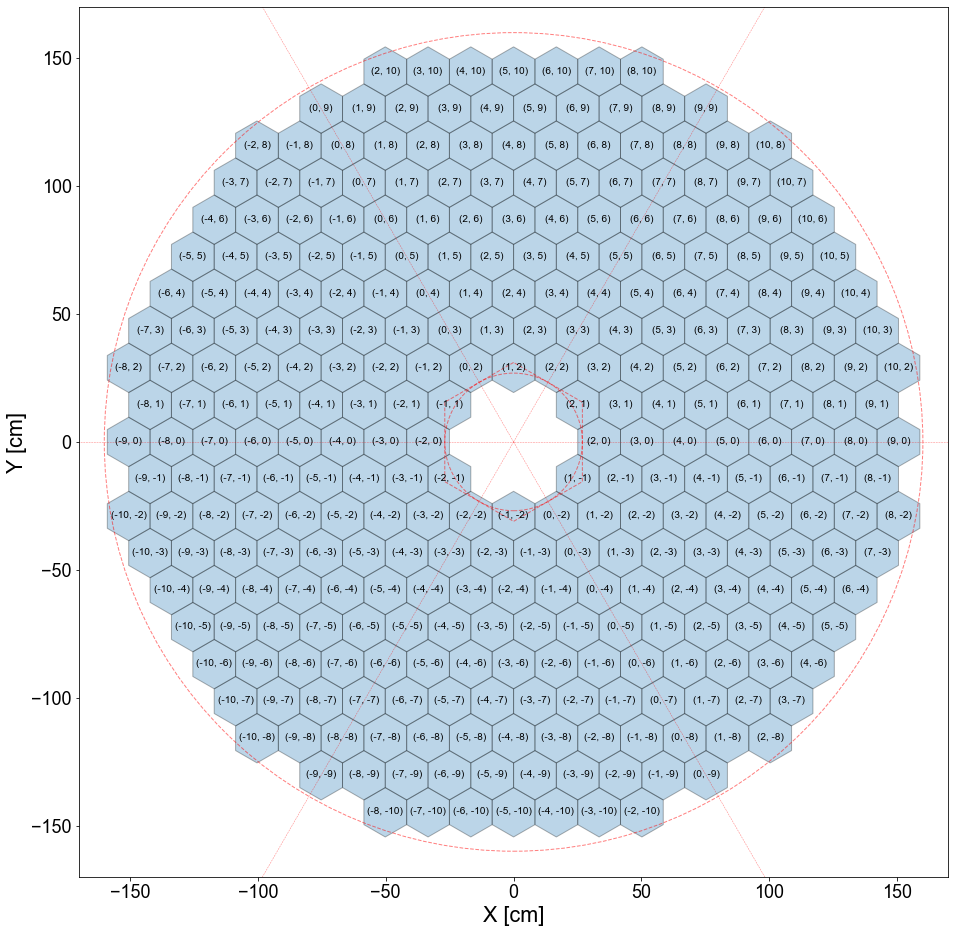

In [8]:
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_aspect('equal')

pt.draw_hgcal_layer(ax)

plt.savefig('plots/wafer_uv_mapping.pdf')
plt.show()

findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'cursive' not found because none of the following families were found: Apple Chancery, Textile, Zapf Chancery, Sand, Script MT, Felipa, cursive


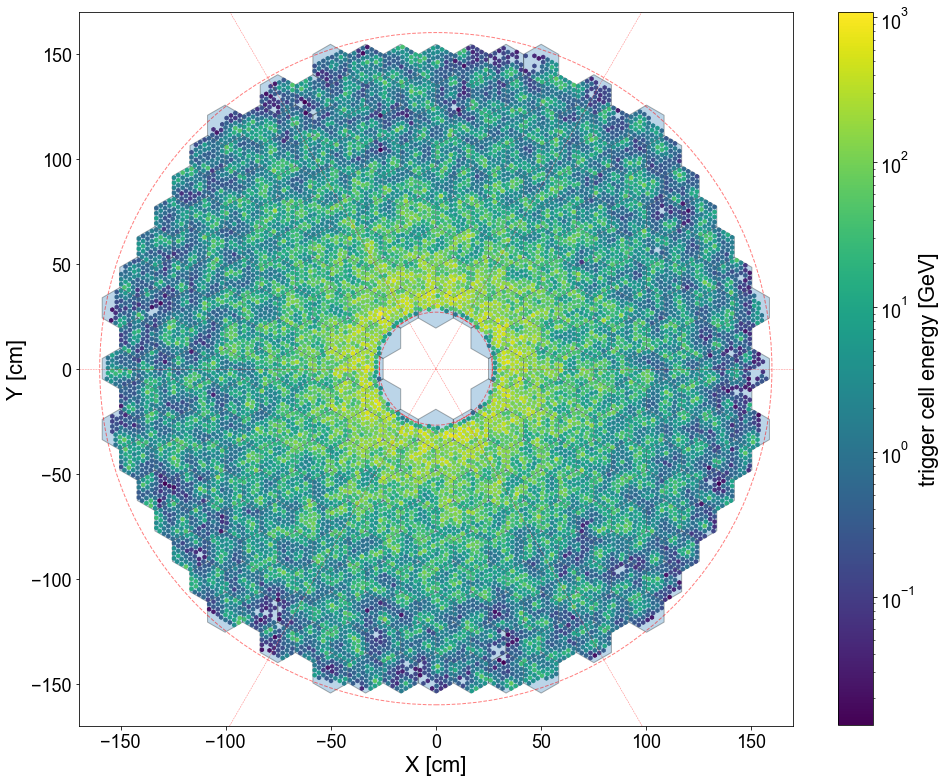

In [9]:
# Draw some events overlaid

# get the data and apply some cuts
#event_tc = df_cut.loc[event_ix]
#event_gen = df_gen.loc[event_ix]

group_wafer = event_tc.groupby(['tc_waferu', 'tc_waferv'])
wafer_sums = group_wafer.sum()

fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_aspect('equal')

pt.draw_hgcal_layer(ax, include_index=False)
              
tc_sums = event_tc.groupby(['tc_x', 'tc_y']).sum()
tc_energy = tc_sums['tc_energy'].values
x, y = tc_sums.index.get_level_values(0).values, tc_sums.index.get_level_values(1).values
scat = ax.scatter(x, y,
                  marker=(6, 0, 0), 
                  s=15, 
                  c=tc_energy,
                  zorder=2,
                  norm=matplotlib.colors.LogNorm()
                 )

cbar = fig.colorbar(scat, ax=ax, shrink=0.82)
cbar.set_label('trigger cell energy [GeV]')

plt.savefig('plots/wafer_occupancy_test.pdf')
plt.show()

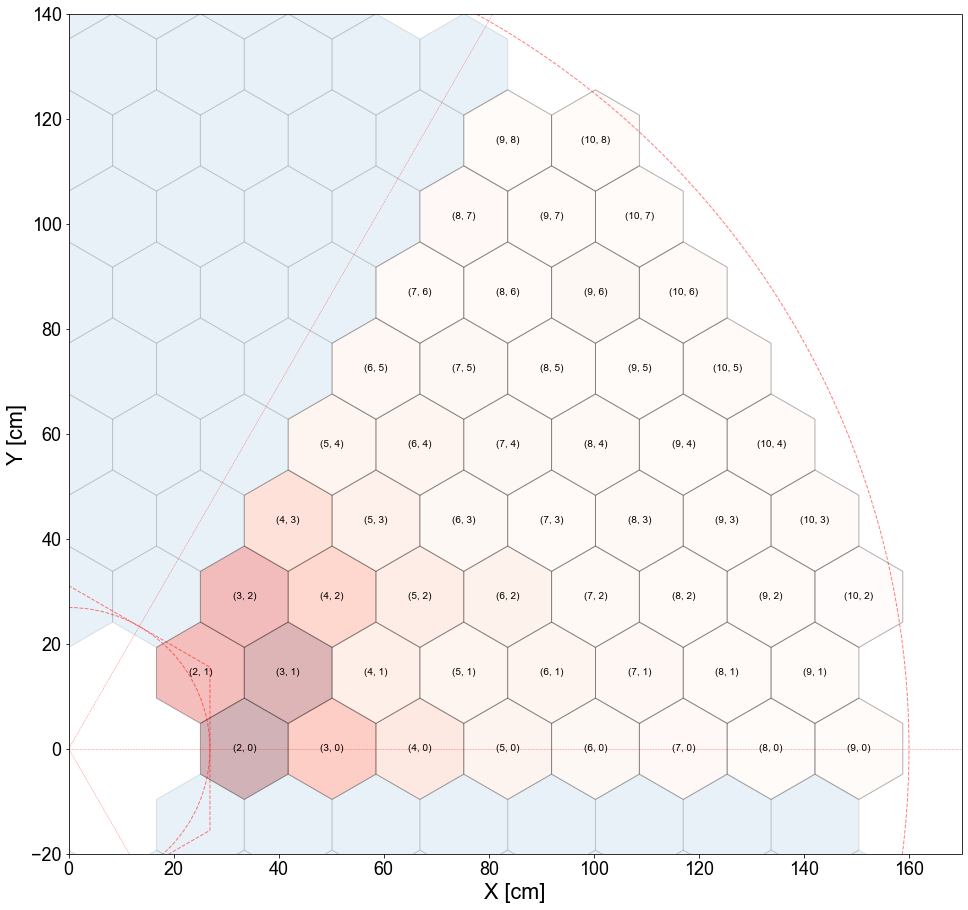

In [10]:
# Draw some events overlaid in the first wedge

# make some plots
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_aspect('equal')

wedge_condition = 'tc_waferu >= 2 and tc_waferu > tc_waferv and tc_waferv >= 0'
wafer_sums = event_tc.query(wedge_condition).groupby(['tc_waferu', 'tc_waferv']).sum()
pt.draw_hgcal_layer(ax, wafer_data=wafer_sums['tc_energy'], single_wedge=True, include_index=True)
    
#ax.add_patch(poly)
# overlay trigger cells.  Combine energy deposits from different events using groupby.
tc_sums = event_tc.query(wedge_condition).groupby(['tc_x', 'tc_y']).sum()
tc_energy = tc_sums['tc_energy'].values
x, y = tc_sums.index.get_level_values(0).values, tc_sums.index.get_level_values(1).values
marker_size = 20. #/ (1 + np.exp(-tc_energy)/10)
#scat = ax.scatter(x, y,
#                  marker='o', #(6, 0, 0), 
#                  s=marker_size, 
#                  c=tc_energy,
#                  zorder=2,
#                  norm=matplotlib.colors.LogNorm()
#                 )
#
#cbar = fig.colorbar(scat, ax=ax, shrink=0.82)
#cbar.set_label('trigger cell energy [a.u.]')

plt.savefig('plots/first_wedge_indexing.png')
plt.show()

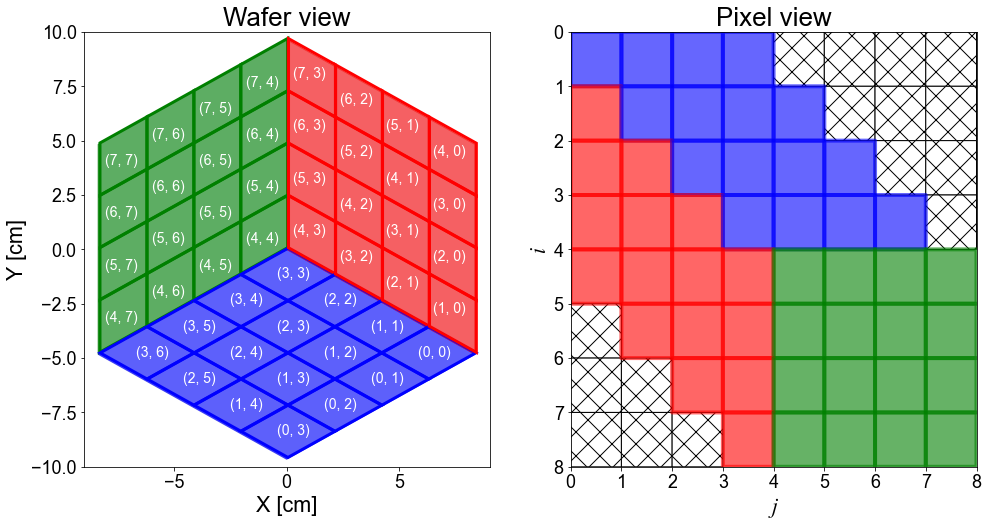

In [11]:
# Draw a single module
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

ax = axes[0]
#ax.set_aspect('equal')

#ax.add_patch(poly)
# overlay trigger cells.  Combine energy deposits from different events using groupby.
tc_uv = (4, 3)
wafer_tc = event_tc.query(f'tc_waferu == {tc_uv[0]} and tc_waferv == {tc_uv[1]}')
tc_data = wafer_tc.groupby(['tc_cellu', 'tc_cellv']).sum()['tc_energy']

pt.draw_single_module(ax, do_fill=True, include_tc_index=True)
ax.set_title('Wafer view')

ax = axes[1]

pt.draw_single_module_pixels(ax)
ax.set_title('Pixel view')
#ax.axis('off')


plt.savefig('plots/tc_uv_mapping.pdf')
plt.show()

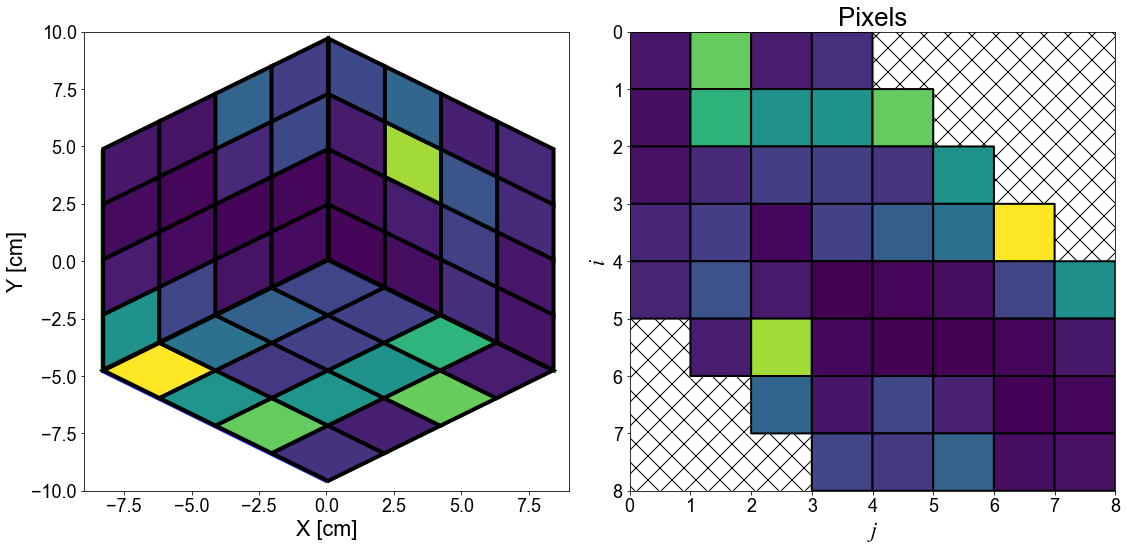

In [22]:
# Draw a single module
fig, axes = plt.subplots(1, 2, figsize=(16, 8), sharey=False)

ax = axes[0]
#ax.set_aspect('equal')

# overlay trigger cells.  Combine energy deposits from different events using groupby.
tc_uv = (4, 3)
pt.draw_single_module(ax, cell_data=tc_data, do_fill=True, include_tc_index=False)
#ax.axis('off')

ax = axes[1]
pt.draw_single_module_pixels(ax, cell_data=tc_data)

plt.tight_layout()
plt.savefig('plots/tc_uv_mapping.pdf')
plt.show()

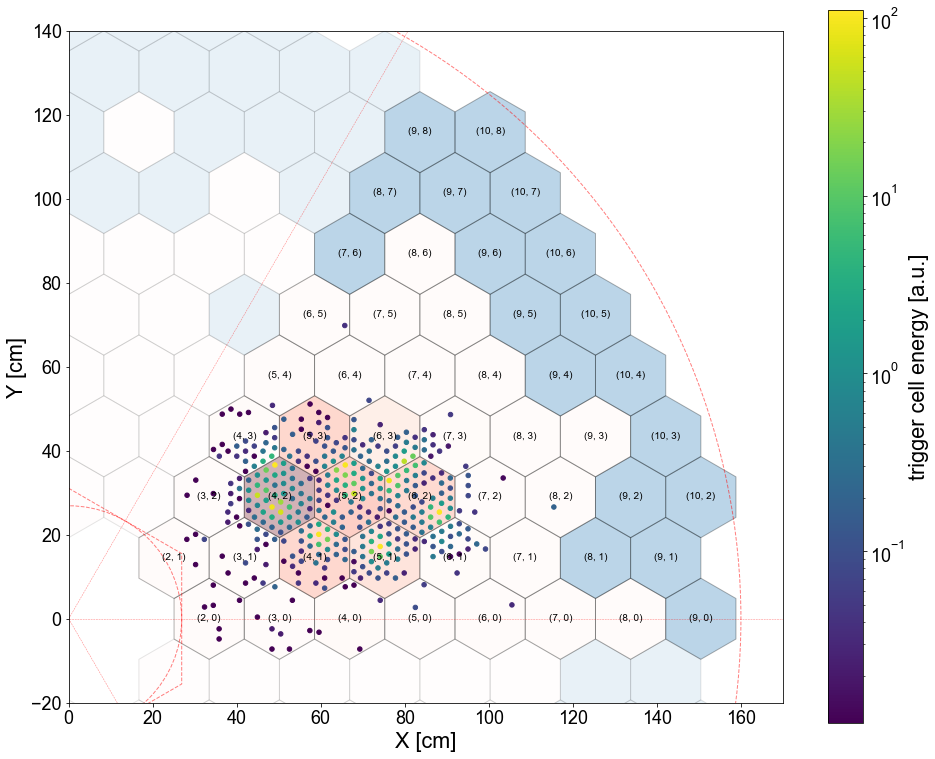

In [13]:
# Draw events within a single hex neighborhood

# make some plots
fig, ax = plt.subplots(1, figsize=(16, 16))
ax.set_aspect('equal')

# get the events centered on neighborhood
uv = (5, 2)
hex_neighbor = gt.hex_neighbors(uv)
wafer_group = df_cut.groupby(['event', 'tc_waferu', 'tc_waferv'])
energy_max_idx = wafer_group.sum()[['tc_energy']].groupby(level=0).idxmax()['tc_energy'].to_list()
wafer_emap = pd.DataFrame(energy_max_idx, columns=['event', 'waferu', 'waferv']).set_index(['waferu', 'waferv'])
wafer_mask = wafer_emap.index.isin(hex_neighbor)
events = wafer_emap[wafer_mask]['event'].values

wafer_data = df_cut.loc[events].groupby(['tc_waferu', 'tc_waferv']).sum()['tc_energy' ]
pt.draw_hgcal_layer(ax, wafer_data=wafer_data, single_wedge=True, include_index=True)

#ax.add_patch(poly)
# overlay trigger cells.  Combine energy deposits from different events using groupby.
random_e = np.random.choice(events, size=10, replace=False)
tc_sums = event_tc.loc[random_e].query(wedge_condition).groupby(['tc_x', 'tc_y']).sum()
tc_energy = tc_sums['tc_energy'].values
x, y = tc_sums.index.get_level_values(0).values, tc_sums.index.get_level_values(1).values
marker_size = 20. #/ (1 + np.exp(-tc_energy)/10)
scat = ax.scatter(x, y,
                  marker='o', #(6, 0, 0), 
                  s=marker_size, 
                  c=tc_energy,
                  zorder=2,
                  norm=matplotlib.colors.LogNorm()
                 )

cbar = fig.colorbar(scat, ax=ax, shrink=0.82)
cbar.set_label('trigger cell energy [a.u.]')

plt.savefig('plots/first_wedge_neighborhood.png')
plt.show()

In [14]:
# Draw neighborhood of modules

# get the data and apply some cuts
event_tc = df_cut
group_wafer = event_tc.groupby(['tc_layer', 'tc_waferu', 'tc_waferv'])
wafer_sums = group_wafer.sum()
uv_max = wafer_sums['tc_energy'].idxmax()[1:]
xy_max = gt.hex_to_cartesian(uv_max)

# draw each module 
coord = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [-1, -1], [0, -1], [-1, 0]])

# make some plots
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.set_aspect('equal')

# draw hexegonal grid
cmap = matplotlib.cm.get_cmap('Reds')
for u, v in coord:
    pt.draw_single_module(ax, uv=(u, v))
    
# overlay trigger cells.  Combine energy deposits from different events using groupby.
tc_energy_max = event_tc['tc_energy'].max()
layer_tc = event_tc.query('tc_layer == 1')
tc_energy = layer_tc['tc_energy'].values
#tc_energy = event_tc.tc_energy.values
x, y = layer_tc.tc_x.values - xy_max[0], layer_tc.tc_y.values - xy_max[1]
marker_size = 95. #/ (1 + np.exp(-tc_energy)/10)
cmap = matplotlib.cm.get_cmap('viridis')
scat = ax.scatter(x, y,
                  marker='o', #(6, 0, 0), 
                  s=marker_size, 
                  c=tc_energy,
                  norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=tc_energy_max),
                  zorder=2,
                 )

ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
##ax.set_title(f'event {event_ix}, 

cbar = fig.colorbar(scat, ax=ax, shrink=0.82)
cbar.set_label('trigger cell energy [GeV]')

scat_anim = ax.scatter([], [], marker='o', s=marker_size, zorder=2)
cmap = matplotlib.cm.get_cmap('viridis')
layer_tc = df_event.query(f'tc_layer == {2*i + 1}')
tc_energy = layer_tc['tc_energy'].values
pos = np.array([layer_tc.tc_x.values - xy_offset[0], layer_tc.tc_y.values - xy_offset[1]]).T

scat.set_color(cmap(np.log(tc_energy)))
scat.set_offsets(pos)
ax.set_title(f'layer {2*i + 1}')

# plot the cluster graphs
fig.tight_layout()
ani = animation.FuncAnimation(fig, update_plot, 

SyntaxError: unexpected EOF while parsing (<ipython-input-14-0221121f9fab>, line 62)

In [ ]:
# Animate shower by layers
from matplotlib import animation
import utils.plot_tools as pt

# get the data and apply some cuts
event_tc = df_cut
group_wafer = event_tc.groupby(['tc_layer', 'tc_waferu', 'tc_waferv'])
wafer_sums = group_wafer.sum()
uv_max = wafer_sums['tc_energy'].idxmax()[1:]
xy_max = gt.hex_to_cartesian(uv_max)

# draw each module 
coord = np.array([[0, 0], [0, 1], [1, 0], [1, 1], [-1, -1], [0, -1], [-1, 0]])

# make some plots
fig, ax = plt.subplots(1, figsize=(12, 12))
ax.set_aspect('equal')

# draw hexegonal grid
cmap = matplotlib.cm.get_cmap('Reds')
for u, v in coord:
    pt.draw_single_module(ax, uv=(u, v))
    
# overlay trigger cells.  Combine energy deposits from different events using groupby.
tc_energy_max = event_tc['tc_energy'].max()
layer_tc = event_tc.query('tc_layer == 1')
tc_energy = layer_tc['tc_energy'].values
#tc_energy = event_tc.tc_energy.values
x, y = layer_tc.tc_x.values - xy_max[0], layer_tc.tc_y.values - xy_max[1]
marker_size = 95. #/ (1 + np.exp(-tc_energy)/10)
cmap = matplotlib.cm.get_cmap('viridis')
scat = ax.scatter(x, y,
                  marker='o', #(6, 0, 0), 
                  s=marker_size, 
                  c=tc_energy,
                  norm=matplotlib.colors.LogNorm(vmin=0.1, vmax=tc_energy_max),
                  zorder=2,
                 )

ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)
ax.set_xlabel('X [cm]')
ax.set_ylabel('Y [cm]')
##ax.set_title(f'event {event_ix}, 

cbar = fig.colorbar(scat, ax=ax, shrink=0.82)
cbar.set_label('trigger cell energy [GeV]')

scat_anim = ax.scatter([], [], marker='o', s=marker_size, zorder=2)
def update_plot(i, df_event, scat, xy_offset, ax):
    cmap = matplotlib.cm.get_cmap('viridis')
    layer_tc = df_event.query(f'tc_layer == {2*i + 1}')
    tc_energy = layer_tc['tc_energy'].values
    pos = np.array([layer_tc.tc_x.values - xy_offset[0], layer_tc.tc_y.values - xy_offset[1]]).T
    
    scat.set_color(cmap(np.log(tc_energy)))
    scat.set_offsets(pos)
    ax.set_title(f'layer {2*i + 1}')
    
    return scat,

# plot the cluster graphs
fig.tight_layout()
ani = animation.FuncAnimation(fig, update_plot, 
                              frames=range(14),
                              interval=400,
                              fargs=(event_tc, scat_anim, xy_max, ax)
                             )

ani.save('plots/test_shower_animation.gif', dpi=80)